<a href="https://colab.research.google.com/github/H-a-m-za/Sudoko/blob/main/Project_Phase_1_Guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt

# Input your image
I'm using an online example. You should import the different test cases provided.

In [10]:
# Switch between the following two samples if you want to see different examples
#req = urllib.request.urlopen('https://live.staticflickr.com/8027/6978422072_33ac92fe1a_b.jpg')
req = urllib.request.urlopen('https://sources.roboflow.com/dcbM99GUgvVCEMo4F2rq8vaVApB2/DSJGI2e7g77XqctWIGQG/original.jpg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, -1) # 'Load it as it is'
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert to grayscale
We don't need any color information.

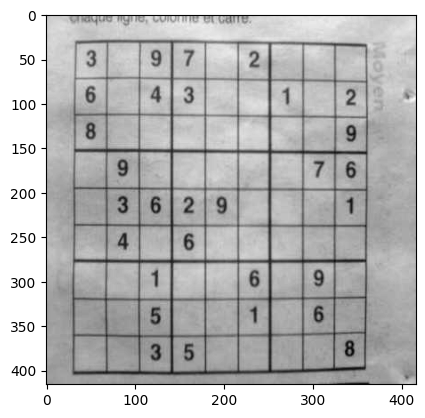

In [3]:
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray, cmap="gray");

# Thresholding step
We don't need the full scale of grayscale either, just binary. But, is ordinary thresholding enough? Or is "adaptive thresholding" better?

Do your research!

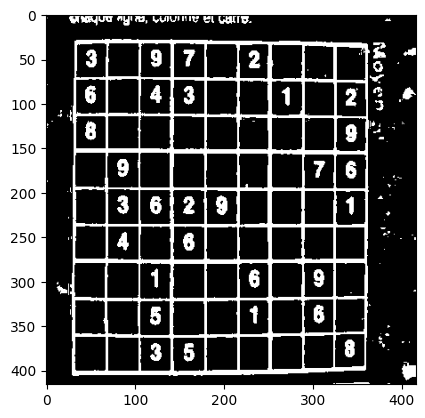

In [4]:
img_gray_threshed = cv2.adaptiveThreshold(src=img_gray,
    maxValue=255,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=111,
    C=5
)
plt.imshow(img_gray_threshed, cmap="gray");

# Detect the lines
One way is to use Hough transform. It may not be the best way, there are other ways, and I've done zero noise removal in this guide so far.

This is very sub-optimal and will most likely not work reliably on all cases. Do your research!

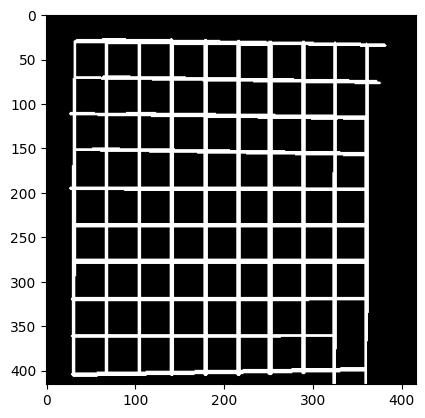

In [5]:
# Detect lines that are not smaller in length than:
minLineLength = min(img_gray_threshed.shape[0],img_gray_threshed.shape[1])/2

lines = cv2.HoughLinesP(
    image=img_gray_threshed,
    rho=1,
    theta=np.pi/180,
    threshold=200,
    minLineLength=minLineLength,
    maxLineGap=17
)

tmp_img = np.zeros_like(img_gray_threshed, dtype = np.uint8)
for x1, y1, x2, y2 in lines[:,0]: cv2.line(tmp_img,(x1,y1),(x2,y2),(255,0,0),2)
plt.imshow(tmp_img, cmap='gray');

# Find the intersections between the lines
Lots of magic numbers here. How to tweak? How to generalize? Do your research!

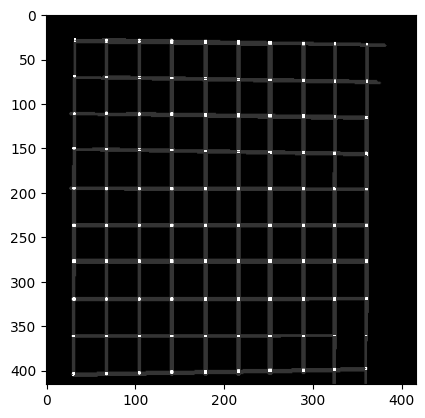

In [6]:
tmp_img2 = np.zeros_like(img_gray_threshed, dtype = np.uint16)

def angle_between_lines(line1, line2):
    l1x1, l1y1, l1x2, l1y2 = line1
    l2x1, l2y1, l2x2, l2y2 = line2
    a1 = np.rad2deg(np.arctan2(l1y2 - l1y1, l1x2 - l1x1))
    a2 = np.rad2deg(np.arctan2(l2y2 - l2y1, l2x2 - l2x1))
    return np.abs(a1 - a2)

def intersection_point(line1, line2):
    # https://en.wikipedia.org/wiki/Line%E2%80%93line_intersection
    l1x1, l1y1, l1x2, l1y2 = line1
    l2x1, l2y1, l2x2, l2y2 = line2
    nx = (l1x1*l1y2-l1y1*l1x2)*(l2x1-l2x2)-(l2x1*l2y2-l2y1*l2x2)*(l1x1-l1x2)
    ny = (l1x1*l1y2-l1y1*l1x2)*(l2y1-l2y2)-(l2x1*l2y2-l2y1*l2x2)*(l1y1-l1y2)
    d = (l1x1-l1x2)*(l2y1-l2y2)-(l1y1-l1y2)*(l2x1-l2x2)
    px = int(nx / d)
    py = int(ny / d)
    return (px, py)

def point_on_line(point, line):
    def distance(pfrom, pto): return np.sqrt((pfrom[0] - pto[0])**2 + (pfrom[1] - pto[1])**2)
    diff = distance(point, line[0:2]) + distance(point, line[2:4]) - distance(line[0:2], line[2:4])
    return np.abs(diff) < 75

intersections = []
num_of_lines = len(lines[:,0])
for i in range(num_of_lines):
    for j in range(i+1, num_of_lines):
        line1 = lines[i,0]
        line2 = lines[j,0]
        if (line1 is line2): continue
        a = angle_between_lines(line1, line2)
        if (a < 80 or a > 100): continue
        p = intersection_point(line1, line2)
        if point_on_line(p, line1) and point_on_line(p, line2):
            tmp_img2[p[::-1]] = 5000
            intersections.append(p[::-1])

plt.imshow(tmp_img2 + tmp_img, cmap="gray", vmin=0, vmax=1255);

# Take the outermost intersection points
But who said the outermost intersection points will always form the sudoku frame?

Can't use this method reliably! Do your research!

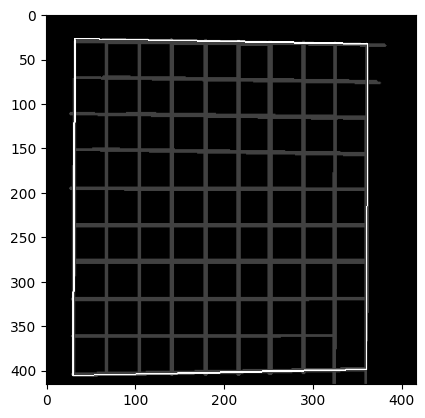

In [7]:
p1 = sorted(intersections, key = lambda p: p[0] + p[1])[0] # topleft
p2 = sorted(intersections, key = lambda p: p[0] - p[1])[0] # topright
p3 = sorted(intersections, key = lambda p: p[0] + p[1])[-1] # bottright
p4 = sorted(intersections, key = lambda p: p[1] - p[0])[0] # bottleft
coords = np.int32([[p1[::-1], p2[::-1], p3[::-1], p4[::-1]]])
tmp_img3 = np.zeros_like(img_gray_threshed, dtype = np.int32)
tmp_img3 = cv2.polylines(tmp_img3, coords, isClosed=True, color=(2550,0,0))
plt.imshow(tmp_img3 + tmp_img, cmap="gray", vmax=1000);

# Perform a perspective transform
Thankfully, if you got the frame right, this step is straight-forward. No research to be done here. (=

Just try not to go insane over the amount of inconsistency in coordinates between Numpy and OpenCV.

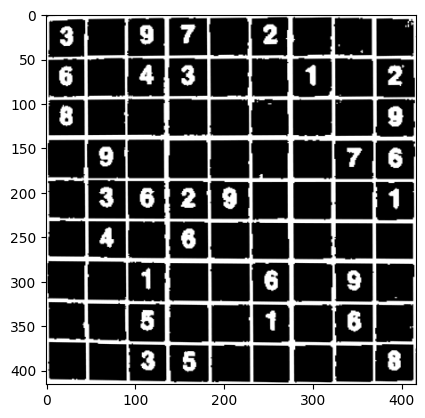

In [8]:
y, x = img_gray_threshed.shape
src_coords = np.float32([[0,0], [x,0], [x,y], [0,y]])
dst_coords = np.float32([[p1[::-1], p2[::-1], p3[::-1], p4[::-1]]])
img_gray_threshed_warped = cv2.warpPerspective(
    src=img_gray_threshed,
    M=cv2.getPerspectiveTransform(dst_coords, src_coords),
    dsize=img_gray_threshed.shape[::-1]
)
plt.imshow(img_gray_threshed_warped, cmap="gray");

# Separate the number tiles
Finally, you get each value in a tile of its own, ready to go to phase 2 (OCR).

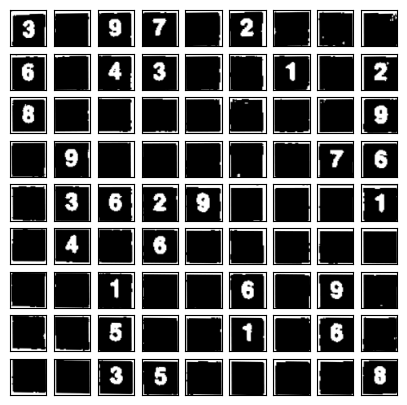

In [9]:
M = img_gray_threshed_warped.shape[0] // 9
N = img_gray_threshed_warped.shape[1] // 9
number_tiles = []
for i in range(9):
    number_tiles.append([])
    for j in range(9):
        tile = img_gray_threshed_warped[i*M:(i+1)*M, j*N:(j+1)*N]
        number_tiles[i].append(tile)

_, axes = plt.subplots(9, 9, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(number_tiles[i][j], cmap="gray");
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)